# Larger Neural Networks 

**Author**

> - [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)  



**Prerequisites**

- [Regression](https://datascience.quantecon.org/../appplications/regression.html)  


**Outcomes**

- Use pytorch to fit multi-layer perceptrons

In [1]:
# Uncomment following line to install on colab
#! pip install pytorch

## Introduction

State of the art neural networks have billions of parameters and are trained with billions of parameters. For example, GPT-3, a well-known deep learning model for natural language, has 175 billion parameters and was was trained on about 500 billion observations. 

Efficient computing is essential to fit such large models. Efficient code that can be run in parallel on multiple GPUs is needed. scikit-learn cannot do this. Fortunately, there are high quality python packages that can. The two most widely used are TensorFlow and PyTorch. 

This notebook will go over the basics of PyTorch. While we won't be able to fit models as large as GPT-3 ([unless you have a few million dollars to rent GPUs](https://lambdalabs.com/blog/demystifying-gpt-3/#1)), working with models with millions of parameters is very feasible. 

### Dataset

To begin with, we will use the same King County housing price data as in the regression lecture. 

This dataset contains sales prices on houses in King County (which
includes Seattle),
Washington, from May 2014 to May 2015.

The data comes from
[Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction) . Variable definitions and additional documentation are available at that link.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import model_selection

def kc_house_data(url = "https://datascience.quantecon.org/assets/data/kc_house_data.csv"):
    df = pd.read_csv(url)
    X = df.drop(["price", "date", "id"], axis=1).copy()
    # convert everything to be a float for later on
    for col in list(X):
            X[col] = X[col].astype(float)
    y = np.log(df["price"])
    df["log_price"] = y    
    return(X, y, df)

X, y, df = kc_house_data()

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

### scikit-learn

Now let's use scikit-learn to fit the same model as in the `regression` notebook.

This is a feed forward network with two layers consisting of 30 and 20 units. 

In [106]:
from sklearn import neural_network, preprocessing, pipeline, metrics

nn_scaled_model = pipeline.make_pipeline(
    preprocessing.StandardScaler(),  
    neural_network.MLPRegressor((30, 20), 
    # we'll specify some options, but except for verbose, these are the defaults
                                activation='relu', 
                                solver='adam', alpha=0.0,
                                batch_size=200, verbose=False, max_iter=200) 
)

This model is not that big, so we can fit in a reasonable amount of time using scikit-learn.

In [107]:
nn_scaled_model.fit(X, y)

Iteration 1, loss = 43.39193093
Iteration 2, loss = 5.13340433
Iteration 3, loss = 2.10395002
Iteration 4, loss = 1.39677173
Iteration 5, loss = 1.06140329
Iteration 6, loss = 0.84967567
Iteration 7, loss = 0.69311232
Iteration 8, loss = 0.56785824
Iteration 9, loss = 0.46136917
Iteration 10, loss = 0.36982295
Iteration 11, loss = 0.29270858
Iteration 12, loss = 0.23141861
Iteration 13, loss = 0.18287467
Iteration 14, loss = 0.14634622
Iteration 15, loss = 0.11995077
Iteration 16, loss = 0.09990708
Iteration 17, loss = 0.08540047
Iteration 18, loss = 0.07463523
Iteration 19, loss = 0.06554504
Iteration 20, loss = 0.05950341
Iteration 21, loss = 0.05390285
Iteration 22, loss = 0.04940201
Iteration 23, loss = 0.04650931
Iteration 24, loss = 0.04316570
Iteration 25, loss = 0.04075892
Iteration 26, loss = 0.03884149
Iteration 27, loss = 0.03687895
Iteration 28, loss = 0.03571060
Iteration 29, loss = 0.03451115
Iteration 30, loss = 0.03334200
Iteration 31, loss = 0.03261639
Iteration 32, lo

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(alpha=0.0, batch_size=200,
                              hidden_layer_sizes=(30, 20), verbose=True))])

In [5]:
print(f"This model has {sum(np.product(np.shape(c)) for c in nn_scaled_model.steps[1][1].coefs_)} coefficients.")
print(f"There are {len(y)} observations.")

This model has 1160 coefficients.
There are 21613 observations.


In [6]:
mse_nn_scaled = metrics.mean_squared_error(y, nn_scaled_model.predict(X))

print(f"Scaled mse {mse_nn_scaled}")

Scaled mse 0.032467442067512495


### PyTorch

Let's fit a similar model using PyTorch. 

Compared to scikit-learn, we must specify more details when using PyTorch. That is, PyTorch has a lower level interface. This means we must write more code, but we also have more control over all details.  

There are python packages with a higher level interface for PyTorch, such as [fastai](https://docs.fast.ai/) and [skorch](https://skorch.readthedocs.io/en/stable/).


In [29]:
import torch

# pytorch has some torch.utils.dataloader for batching and shuffling. 
# These utilities want the data in this sort of class
class xyDataSet(torch.utils.data.Dataset):  # inherit from torch.utils.data.Dataset
  def __init__(self, x, y, device="cpu"): # constructor
    # similar to numpy, pytorch has a special array class for efficient computation, called tensor
    self.x = torch.tensor(x).float().to(device)
    self.y = torch.tensor(y).float().to(device)
  def __getitem__(self, index):
    return self.x[index], self.y[index]
  def __len__(self):
    return len(self.x)


In [12]:
# define the model
class MLP(torch.nn.Module): # inherit from torch.nn.Module. This gives us things like .to(device) and .parameters()
  def __init__(self, nfeatures, layer_sizes):
    super(MLP, self).__init__() # initialize the superclass, this is required
    if (len(layer_sizes) != 2):
      raise ValueError("Assumes 2 layers")
    self.mlp = torch.nn.Sequential( 
      torch.nn.Linear(nfeatures, layer_sizes[0]), 
      torch.nn.ReLU(),
      torch.nn.Linear(layer_sizes[0], layer_sizes[1]),
      torch.nn.ReLU(),
      torch.nn.Linear(layer_sizes[1],1)
    )
    
  def forward(self, x): # define the forward pass. this gets called when you call mlp(x)
    return self.mlp(x)

In [122]:

class MLP_scaled: 
  # this class is meant to enable usage similar to sklearn's pipeline and other models. 
  # specifically, it has fit() and predict() methods.
  def __init__(self, x, y, layer_sizes=[30,20],device="cpu"):
    self.data = xyDataSet(x, y, device=device)
    self.mlp = MLP(x.shape[1], layer_sizes).to(device)
    self.xmeans = self.data.x.mean(0, keepdim=True)
    self.xdevs = self.data.x.std(0, keepdim=True)

  def fit(self, batch_size=200, shuffle=True, epochs=200, tol=1e-4, verbose=True):
    self.xmeans = self.data.x.mean(0, keepdim=True)
    self.xdevs = self.data.x.std(0, keepdim=True)
    dataloader = torch.utils.data.DataLoader(self.data, batch_size=batch_size, shuffle=True)
    self.mlp.train() # set the model to training mode    
    optimizer = torch.optim.Adam(self.mlp.parameters(), lr=0.001, betas=(0.9,0.999), eps=1e-8)
    max_stuck = 10
    lossfn = torch.nn.MSELoss(reduction='mean')
    bestloss = 1e10
    nstuck = 0
    # the main training loop. this is meant to be mimic sklearn's fit(). 
    # the use of batching and the optimizer is the same, but the convergence criterion might be slightly different.
    for epoch in range(epochs):
      for i, (x, y) in enumerate(dataloader):  # loop over batches
        # compute the loss function
        x = self.standardize(x)
        yhat = self.mlp(x).flatten()
        loss = lossfn(yhat, y)

        optimizer.zero_grad()
        # compute the gradients
        loss.backward()
        # update the parameters 
        optimizer.step()                
      if (verbose):
        print(f"Epoch {epoch} loss {loss}")

      with torch.no_grad():
        yhat = self.mlp(self.standardize(self.data.x)).flatten()
        aloss = lossfn(yhat, self.data.y)
      if (aloss < bestloss - tol):
        bestloss = aloss
        nstuck = 0
      else:
        nstuck = nstuck + 1      
      if (nstuck > max_stuck):
        break
    return(aloss)

  def standardize(self, x):
    return (x - self.xmeans) / self.xdevs

 
  def predict(self, X):
    return(self.mlp(self.standardize(X)))


tmlp = MLP_scaled(X.to_numpy(), y.to_numpy(), [30, 20])

Now, we can fit this model.

In [123]:
tmlp.fit(epochs=200, batch_size=200)

Epoch 0 loss 40.491573333740234
Epoch 1 loss 7.941810131072998
Epoch 2 loss 4.720028400421143
Epoch 3 loss 2.479236364364624
Epoch 4 loss 1.9418965578079224
Epoch 5 loss 3.6526339054107666
Epoch 6 loss 1.449804425239563
Epoch 7 loss 1.0574568510055542
Epoch 8 loss 0.5299814343452454
Epoch 9 loss 0.4952147901058197
Epoch 10 loss 0.6240981221199036
Epoch 11 loss 0.16195601224899292
Epoch 12 loss 0.24512670934200287
Epoch 13 loss 0.6002450585365295
Epoch 14 loss 0.38630178570747375
Epoch 15 loss 0.10161130130290985
Epoch 16 loss 0.2708132565021515
Epoch 17 loss 0.043772902339696884
Epoch 18 loss 0.0987187922000885
Epoch 19 loss 0.12769366800785065
Epoch 20 loss 0.08313051611185074
Epoch 21 loss 0.19967402517795563
Epoch 22 loss 0.08035913109779358
Epoch 23 loss 0.09878825396299362
Epoch 24 loss 0.04391440376639366
Epoch 25 loss 0.09564924240112305
Epoch 26 loss 0.047616686671972275
Epoch 27 loss 0.09026544541120529
Epoch 28 loss 0.09229080379009247
Epoch 29 loss 0.06822967529296875
Epoch 

tensor(0.0420)

The performance should be similar to the sklearn model above. In fact, you might find the run time is a bit longer. 

### GPU

To see the benefits of pytorch, we need to execute code on the GPU. PyTorch makes it very easy to move execution onto GPUs.

In [117]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [112]:
tmlp_gpu = MLP_scaled(X.to_numpy(), y.to_numpy(), [30, 20], device=device)  # create a model on the GPU

In [116]:
tmlp_gpu.fit(epochs=200, batch_size=200)

Epoch 0 loss 0.8189539909362793
Epoch 1 loss 0.17582881450653076
Epoch 2 loss 0.06308358162641525
Epoch 3 loss 0.05912668630480766
Epoch 4 loss 0.06194499507546425
Epoch 5 loss 0.047881800681352615
Epoch 6 loss 0.058075275272130966
Epoch 7 loss 0.0553312748670578
Epoch 8 loss 0.05017908662557602
Epoch 9 loss 0.04725100100040436
Epoch 10 loss 0.038942426443099976
Epoch 11 loss 0.045667603611946106
Epoch 12 loss 0.04397163540124893
Epoch 13 loss 0.043166570365428925
Epoch 14 loss 0.047655366361141205
Epoch 15 loss 0.043249912559986115
Epoch 16 loss 0.03927473723888397
Epoch 17 loss 0.04984626546502113
Epoch 18 loss 0.03686951845884323
Epoch 19 loss 0.039066482335329056


tensor(0.0385, device='cuda:0')

That's not any faster. What's the problem?

This model is too small to see benefits from using a GPU. The GPU is great at computing predictions and gradients of large neural networks. The GPU doesn't make many of the other steps of fitting faster (checking convergence, iterating through the loop, etc.) Let's try some larger networks.

In [130]:
import time
layers = np.array([30, 20])
epochs = 10
S = 5
times = np.zeros((S, 4))
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for s in range(S):
  layer_sizes = layers * 2**s
  skmlp = pipeline.make_pipeline(
    preprocessing.StandardScaler(),  
    neural_network.MLPRegressor((layer_sizes[0], layer_sizes[1]), 
                                activation='relu', 
                                solver='adam', alpha=0.0,
                                batch_size=200, verbose=False, max_iter=epochs) 
  ) 
  start = time.time()
  skmlp.fit(X, y)
  times[s, 0] = time.time() - start

  tmlp = MLP_scaled(X.to_numpy(), y.to_numpy(), layer_sizes, device='cpu')
  start = time.time()
  tmlp.fit(epochs=epochs, verbose=False)
  times[s, 1] = time.time() - start

  tmlp_gpu = MLP_scaled(X.to_numpy(), y.to_numpy(), layer_sizes, device='cuda')
  start = time.time()
  tmlp_gpu.fit(epochs=epochs, verbose=False)
  times[s, 2] = time.time() - start

  times[s,3] = count_parameters(tmlp.mlp)

/usr/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochasti

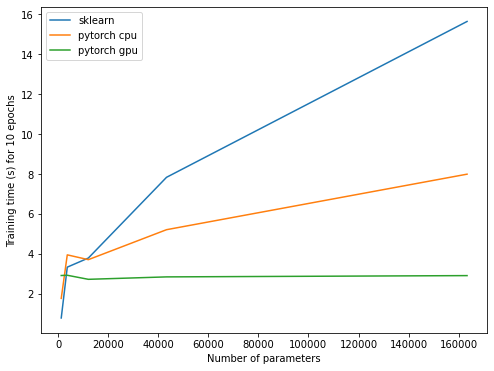

In [131]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(times[:,3], times[:,0], label='sklearn')
ax.plot(times[:,3], times[:,1], label='pytorch cpu')
ax.plot(times[:,3], times[:,2], label='pytorch gpu')
ax.set_xlabel('Number of parameters')
ax.set_ylabel('Training time (s) for 10 epochs')
ax.legend()


For more examples and tutorials, see [the PyTorch documentation](https://pytorch.org/tutorials/index.html).